# Project: an interpretable VAE to study Transcription Factor rewiring

## Introduction

Contact: Carl Herrmann, Daria Doncevic (Heidelberg University carl.herrmann@bioquant.uni-heidelberg.de daria.doncevic@bioquant.uni-heidelberg.de)

Variational Autoencoders are now widely applied to capture the complexity in single-cell omics datasets and can be used to replace complete workflows of data analysis consisting of normalization, clustering, celltype annotation and differential expression analysis. However, due to their non-linear nature, they lack interpretability. As you have learned in week 2 of the course, a subset of VAE models such as the VEGA model ([Seninge *et al* (2021)](https://www.nature.com/articles/s41467-021-26017-0)) can convey intrinsic interpretability by incorporating biological networks directly into their model structure. In VEGA, every node in the latent space corresponds to a biological entity such as a pathway or transcription factor (TF) and is then connected only to the genes in the reconstruction layer that are annotated to that biological entity, making the one-layered decoder sparse. Thus, the activations of the nodes in the latent space can be interpreted as pathway or TF activities. In this project, you are going to focus more on the weights of the decoder connections than on the latent space activities, and see how they differ for different genes for a given TF. We believe that this change in the weights between TF and target genes might indicate a rewiring of the TF in different biological condition.
You are also going to estimate uncertainties for the weights (which also depends on the annotation that is used) and to investigate how the weights change in condition versus control, which we call "Transcription factor rewiring".

## Goal
The goal of this project is to study Transcription factor rewiring in the context of interferon response. Thus, you should focus especially on TFs that are known to play a role in interferon response, such as STAT1, STAT2, and the different IRFs, and their target genes. You can read more about that [in this review](https://www.nature.com/articles/nri3787). To be able to obtain different weights for condition and control, you will have to train two separate models. Since VAEs are probabilistic, you will end up with a different set of weights each time you train the model. Thus, your task will also be to estimate or compute uncertainties for the weights. There are different ways to achieve this:


*   Train each model multiple times (and then compute metrics such as mean and standard deviation for the different weights). Are there genes whose annotation to a given TF seems to be "less certain" than for others?
*   When we train multiple models and then aggregate their results, we also call this an ensemble. Training an ensemble is often expensive in terms of computational time and power. Stochastic Weight Averaging (SWA) has been proposed as a method that can yield more robust weights without the need of training ensembles. The publication is linked [here](https://arxiv.org/pdf/1803.05407), and additional information can be found [here](https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/). Try to implement this approach for your VEGA model.
*   Bayesian Neural Networks do built-in estimation of weight uncertainties. Try to replace your linear layer with a Bayesian layer to obtain these estimates. You can find some information to get you started [in this blogpost](https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825/). More mathematical foundations can also be found [here](https://www.cs.toronto.edu/~duvenaud/distill_bayes_net/public/).

Do not forget to also include some biological speculation/interpretation of your results!

## Data and model

As in week 2, you will use a dataset that contains peripheral blood mononuclear cells (PBMCs) from systemic lupus patients, treated with Interferon beta or untreated (control). You can follow the steps from week 2's notebook to download the data. You will also work with a VEGA-like model, and you can reuse code from week 2 for the implementation.

This time, instead of Reactome pathways, you will use TF regulons from the collecTRI database as a biological prior. Information about this resource and how to obtain the data is available [here](https://github.com/saezlab/CollecTRI). You might want to filter the regulons based on regulon size prior to incorporation into the model.

## Getting Data

In [1]:
#!pip install decoupler
#!pip install scanpy

### scRNAseq data

In [2]:
# download the data
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG' -O PBMC_train.h5ad

In [3]:
import scanpy as sc

# load data as anndata object
pbmc = sc.read_h5ad("PBMC_train.h5ad")
pbmc

AnnData object with n_obs × n_vars = 13515 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
pbmc.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 4430719 stored elements and shape (13515, 6998)>

In [5]:
pbmc.obs

,condition,n_counts,n_genes,mt_frac,cell_type
index,,,,,
AAATTCGACATGAC-1-control,control,2275.0,928,0.0,CD8T
TCAGTTACCTCCCA-1-control,control,1422.0,547,0.0,CD8T
GTAGTGTGTTCGTT-1-control,control,1176.0,505,0.0,CD8T
TAACACCTGTCATG-1-control,control,1113.0,514,0.0,CD8T
CAAGAAGACACTGA-1-control,control,2052.0,851,0.0,CD8T
...,...,...,...,...,...
GATCTTTGCTGTCC-1-stimulated,stimulated,1842.0,660,0.0,CD14+Mono
ATATACGATTTGCT-1-stimulated,stimulated,3266.0,1066,0.0,CD14+Mono
GAGGGATGGTCACA-1-stimulated,stimulated,3185.0,725,0.0,CD14+Mono


In [6]:
pbmc.var

,gene_symbol,n_cells
index,,
AL627309.1,AL627309.1,8
RP11-206L10.9,RP11-206L10.9,11
LINC00115,LINC00115,118
NOC2L,NOC2L,1930
KLHL17,KLHL17,28
...,...,...
SLC19A1,SLC19A1,81
COL6A2,COL6A2,51
FTCD,FTCD,5


In [7]:
print(pbmc.X.toarray())
print(f"Shape(observations x genes): {pbmc.X.toarray().shape}")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape(observations x genes): (13515, 6998)


In [8]:
pbmc.shape

(13515, 6998)

### Regulon data

In [9]:
# processed regulons
import decoupler as dc
regulons = dc.op.collectri(organism='human')
regulons

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


choose regulons

In [10]:
# prompt: filter regulons dataframe where source equal to something in a list like ["STAT1","STAT2"]

filtered_regulons = regulons[regulons['source'].isin(
    [
      "GTF2I",
      "GTF3A"
      "NRF1",
      "ELF1",
      "STAT1",
      "STAT2",
      "IRF9",
      "STAT3",
      "STAT4",
      "STAT5A",
      "STAT5B",
      "IRF3",
      "IRF7",
      "IRF1",
      "IRF5",
     "IRF8",
     ])]
# source for regulons is https://www.nature.com/articles/nri3787
# I also checked every regulon in this list exists in our dataset
filtered_regulons

,source,target,weight,resources,references,sign_decision
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
5,STAT5B,IL2,1.0,ExTRI,10022878,regulon
15,STAT1,CDKN1A,1.0,ExTRI;TFactS;TRRUST,10023678;10866323;11162600;12239594;16449678;2...,PMID
16,STAT3,CDKN1A,1.0,ExTRI;NTNU.Curated;TRRUST,10023678;11114718;11773079;12438313;15063116;1...,PMID
42,STAT4,IL12B,1.0,ExTRI,10037767;12893768,default activation
...,...,...,...,...,...,...
41490,IRF1,hsa-miR-342,1.0,ExTRI,19151778,default activation
41491,IRF9,hsa-miR-342,1.0,ExTRI,19151778,default activation
41503,STAT1,hsa-miR-221-3p,1.0,ExTRI,20110463,default activation
41506,STAT3,hsa-miR-21,1.0,ExTRI,20813833;21685938;22210182;23416424,regulon


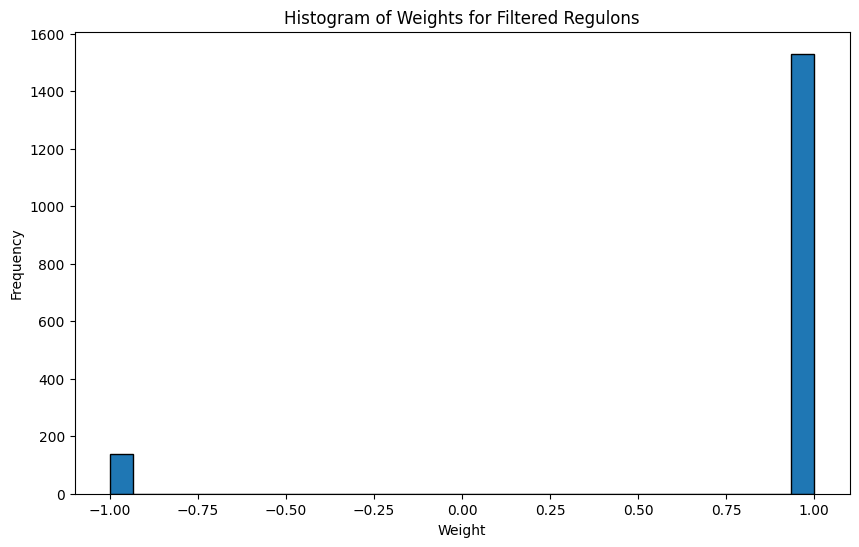

In [11]:
# prompt: create an histogram for dataframe filtered_regulons, column weight

import matplotlib.pyplot as plt

# Assuming 'filtered_regulons' DataFrame and 'weight' column exist
plt.figure(figsize=(10, 6))
plt.hist(filtered_regulons['weight'], bins=30, edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Histogram of Weights for Filtered Regulons')
plt.show()

filter regulons for size, for this, create a histogram for how counts of our chosen regulons in dataframe

source
STAT3     437
STAT1     305
STAT5A    215
IRF1      170
STAT5B    106
IRF3       83
ELF1       80
IRF8       69
STAT2      50
IRF5       37
IRF7       34
STAT4      32
IRF9       29
GTF2I      23
Name: count, dtype: int64


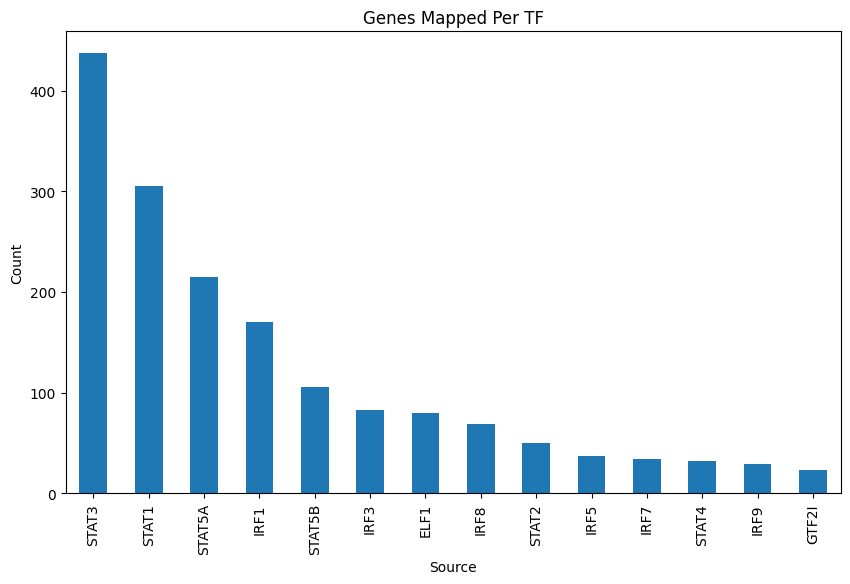

In [12]:
print(filtered_regulons['source'].value_counts())
# prompt: create a histogram for counts of each unique values in source column
# Assuming 'filtered_regulons' DataFrame and 'source' column exist
plt.figure(figsize=(10, 6))
filtered_regulons['source'].value_counts().plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Genes Mapped Per TF')
plt.show()

## Create Mask

this function was copied from exercise, but we do not have a .gmt file

.gmt file format is like this for each line: name, link, gene1, gene2, ...

but we have a dataframe of columns: source(TF), target(gene), weight(-1 or 1)

I believe we should mark -1 in mask if the weight is -1, unlike the previous implementation

Writing our own function / creating our own mask
- convert to polars because i'm more familiar with it
- keep only the gene names in the anndata object, so we wont keep genenames without corresponding data in the mask
- convert the df from long to wide format, values will be weights, columns will be TFs, gene names will stay in rows
-

In [13]:
pbmc.var.index.to_numpy()

array(['AL627309.1', 'RP11-206L10.9', 'LINC00115', ..., 'FTCD', 'DIP2A',
       'S100B'], shape=(6998,), dtype=object)

In [14]:

import polars as pl

extra_nodes_count = 2

# rows should correspond to genes
# cols should correspond to gene sets/TFs
def create_mask(pbmc_tmp):
  tmp = (
    pl
    .from_pandas(filtered_regulons)
    # alice and kerem and yusuf decided to convert all -1 to 1 and remove positive weights restriction
    .with_columns(
        pl.col("weight").replace(-1,1)
    )
    .filter(
        pl.col("target").is_in(pbmc_tmp.var.index.to_numpy())
    ) # 901 x 13 -> 332 x 13
    .pivot(
        on = "source", # new columns
        index = "target", # stays in rows
        values = "weight"
    )
    .fill_null(0)
  )

  for i in range(0,extra_nodes_count):
    node_index = i + 1
    node_name = "unannotated_" + str(node_index)
    tmp = tmp.with_columns(
        pl.lit(1).alias(node_name)
    )

    return tmp

mask_polars_df = create_mask(pbmc)
mask_polars_df


target,STAT5A,STAT5B,STAT4,IRF1,STAT3,GTF2I,STAT1,IRF8,ELF1,IRF3,IRF5,STAT2,IRF7,IRF9,unannotated_1
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""IL2""",1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
"""IRF1""",1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
"""CCND1""",1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"""PRF1""",1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"""IFNG""",1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ZC3HAV1""",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"""ZNF181""",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
"""ZNF230""",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


The exercise also adds fully connected nodes (default 1) to the mask as extra nodes, I am not sure if we want to still do that. and if we are gonna do that, we should create them in pairs as our mask values can be -1 too.

We need to add mask and the TF information to the anndata object

In [15]:
pbmc.uns['_vega'] = dict() #create attribute "_vega" to store the mask and pathway information
pbmc.uns['_vega']['mask'] = mask_polars_df
pbmc.uns['_vega']['gmv_names'] = mask_polars_df.drop("target").columns

pbmc.uns['_vega']

{'mask': shape: (357, 16)
 ┌─────────┬────────┬────────┬───────┬───┬───────┬──────┬──────┬───────────────┐
 │ target  ┆ STAT5A ┆ STAT5B ┆ STAT4 ┆ … ┆ STAT2 ┆ IRF7 ┆ IRF9 ┆ unannotated_1 │
 │ ---     ┆ ---    ┆ ---    ┆ ---   ┆   ┆ ---   ┆ ---  ┆ ---  ┆ ---           │
 │ str     ┆ f64    ┆ f64    ┆ f64   ┆   ┆ f64   ┆ f64  ┆ f64  ┆ i32           │
 ╞═════════╪════════╪════════╪═══════╪═══╪═══════╪══════╪══════╪═══════════════╡
 │ IL2     ┆ 1.0    ┆ 1.0    ┆ 0.0   ┆ … ┆ 0.0   ┆ 0.0  ┆ 0.0  ┆ 1             │
 │ IRF1    ┆ 1.0    ┆ 1.0    ┆ 1.0   ┆ … ┆ 1.0   ┆ 0.0  ┆ 0.0  ┆ 1             │
 │ CCND1   ┆ 1.0    ┆ 1.0    ┆ 0.0   ┆ … ┆ 0.0   ┆ 0.0  ┆ 0.0  ┆ 1             │
 │ PRF1    ┆ 1.0    ┆ 1.0    ┆ 1.0   ┆ … ┆ 0.0   ┆ 0.0  ┆ 0.0  ┆ 1             │
 │ IFNG    ┆ 1.0    ┆ 1.0    ┆ 1.0   ┆ … ┆ 1.0   ┆ 0.0  ┆ 1.0  ┆ 1             │
 │ …       ┆ …      ┆ …      ┆ …     ┆ … ┆ …     ┆ …    ┆ …    ┆ …             │
 │ ZC3HAV1 ┆ 0.0    ┆ 0.0    ┆ 0.0   ┆ … ┆ 0.0   ┆ 0.0  ┆ 0.0  ┆ 1             │
 │

In [16]:
mask_np = mask_polars_df.drop("target").to_numpy()

In [17]:
#filtering genes for in mask
pmbc_genes_subset = pbmc[:, mask_polars_df["target"].to_list()].copy()
pmbc_genes_subset

AnnData object with n_obs × n_vars = 13515 × 357
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors', '_vega'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

## Build the Sparse VAE

In [18]:
import torch; torch.manual_seed(100)
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import math
import numpy as np
np.random.seed(100)
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import scanpy as sc
from collections import OrderedDict
from collections import Counter

# select the right device, depending on whether your Colab runs on GPU or CPU
### IMPORTANT: we recommend to change your runtime to GPU, otherwise the training takes much longer
device = 'cuda'

torch.cuda.is_available()

True

In [19]:
# only change was in positive_weights function, we no longer restrict the weights

class VEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3, clamp_mu = False):
        super(VEGA, self).__init__()

        self.clamp_mu = clamp_mu

        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = DecoderVEGA(mask)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout, z_dropout): #dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout))  #two layer, fully connected encoder with dropout


        self.mu = nn.Sequential(nn.Linear(800, latent_dims),
                                nn.Dropout(p = z_dropout))

        self.sigma = nn.Sequential(nn.Linear(800, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        mu =  self.mu(x)
        #clamp positive

        sigma = torch.exp(self.sigma(x)) # 7/03/2025: THERE WAS A TYPO HERE!!
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z
    
    def clamp_mu(self):
        """
        we think clamping would be better as it would remove mirroring of different runs
        """
        if self.clamp_mu:
            with torch.no_grad():
                self.mu[0].weight.clamp_(min=0)

class DecoderVEGA(nn.Module):
  """
  Define VEGA's decoder (sparse, one-layer, linear, positive)
  """
  def __init__(self,
               mask):
        super(DecoderVEGA, self).__init__()

        self.sparse_layer = nn.Sequential(SparseLayer(mask)) # we define the architecture of the decoder below with the class "SparseLayer"

  def forward(self, x):
    z = self.sparse_layer(x.to(device))
    return(z)

  def weights(self):
      """
      constrain the decoder to positive weights (set negative weigths to zero)
      """
      w = self.sparse_layer[0].weight
      return w


# define a class SparseLayer, that specifies the decoder architecture (sparse connections based on the mask)
class SparseLayer(nn.Module):
  def __init__(self, mask):
        """
        Extended torch.nn module which mask connection
        """
        super(SparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)
        self.weight = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0]))
        self.bias = nn.Parameter(torch.Tensor(mask.shape[1]))
        self.reset_parameters()

        # mask weight
        self.weight.data = self.weight.data * self.mask

  def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input):
        # See the autograd section for explanation of what happens here
        return SparseLayerFunction.apply(input, self.weight, self.bias, self.mask)


######### You don't need to understand this part of the code in detail #########
class SparseLayerFunction(torch.autograd.Function):
    """
    We define our own autograd function which masks it's weights by 'mask'.
    For more details, see https://pytorch.org/docs/stable/notes/extending.html
    """

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask):

        weight = weight * mask # change weight to 0 where mask == 0
        #calculate the output
        output = input.mm(weight.t())
        output += bias.unsqueeze(0).expand_as(output) # Add bias to all values in output
        ctx.save_for_backward(input, weight, bias, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output): # define the gradient formula
        input, weight, bias, mask = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = grad_mask = None

        # These needs_input_grad checks are optional and only to improve efficiency
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
            # change grad_weight to 0 where mask == 0
            grad_weight = grad_weight * mask
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, grad_mask

In [20]:
#training loop
def trainVEGA(vae, data, epochs=60, beta = 0.0001, learning_rate = 0.001):
  #epochs 60 looked enough when we tried 100
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    vae.train() #train mode
    losses = []
    klds = []
    mses = []

    for epoch in range(epochs):
        loss_e = 0
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()
            kld = beta* vae.encoder.kl
            loss = mse +  kld # loss calculation
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()
            vae.decoder.weights() # this used to be positive_weights
            vae.encoder.clamp_mu() # this used to be positive_weights

        losses.append(loss_e/(len(data)*128))
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128))

    return vae, losses, klds, mses

In [21]:
pbmcX = torch.utils.data.DataLoader(pmbc_genes_subset.X.toarray(), batch_size=128) #set up the training data in the right format

In [22]:
vega = VEGA(latent_dims= mask_np.shape[1], input_dims = mask_np.shape[0], mask = mask_np.T, z_dropout = 0.5, dropout = 0.3, clamp_mu=True).to(device)
# model training
vega, vega_losses, vega_klds, vega_mses = trainVEGA(vega, pbmcX, epochs = 20, beta = 0.0001) #takes about 2 mins on GPU # epoch 100

epoch:  0  loss:  82.5851
epoch:  1  loss:  63.211323
epoch:  2  loss:  52.906845
epoch:  3  loss:  48.737755
epoch:  4  loss:  46.038906
epoch:  5  loss:  44.416023
epoch:  6  loss:  43.156223
epoch:  7  loss:  41.97399
epoch:  8  loss:  41.172806
epoch:  9  loss:  40.65438
epoch:  10  loss:  39.3644
epoch:  11  loss:  38.959255
epoch:  12  loss:  38.166973
epoch:  13  loss:  38.16809
epoch:  14  loss:  39.49798
epoch:  15  loss:  38.464302
epoch:  16  loss:  37.255585
epoch:  17  loss:  37.567352
epoch:  18  loss:  36.240005
epoch:  19  loss:  36.70654


check mus

In [23]:
vega.encoder.mu[0].weight

Parameter containing:
tensor([[3.6036e-03, 0.0000e+00, 1.4366e-02,  ..., 0.0000e+00, 8.5448e-07,
         2.7588e-03],
        [2.6493e-02, 3.4345e-02, 5.1010e-03,  ..., 1.5987e-01, 0.0000e+00,
         1.6738e-02],
        [2.2012e-02, 4.6969e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.1933e-02],
        ...,
        [2.9856e-04, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 8.7125e-03,
         2.7003e-04],
        [0.0000e+00, 0.0000e+00, 2.8175e-02,  ..., 0.0000e+00, 2.5077e-03,
         7.1769e-03],
        [2.7662e-02, 0.0000e+00, 1.6705e-02,  ..., 6.7689e-03, 2.7075e-02,
         2.0373e-03]], device='cuda:0', requires_grad=True)

In [24]:
# Create a sample tensor
tensor = vega.encoder.mu[0].weight

# Count positive values
positive_count = (tensor > 0).sum().item()

# Count negative values
negative_count = (tensor < 0).sum().item()

# Count zero values (optional)
zero_count = (tensor == 0).sum().item()

print(f"Original Tensor: {tensor}")
print(f"Number of Positive Values: {positive_count}")
print(f"Number of Negative Values: {negative_count}")
print(f"Number of Zero Values: {zero_count}")

Original Tensor: Parameter containing:
tensor([[3.6036e-03, 0.0000e+00, 1.4366e-02,  ..., 0.0000e+00, 8.5448e-07,
         2.7588e-03],
        [2.6493e-02, 3.4345e-02, 5.1010e-03,  ..., 1.5987e-01, 0.0000e+00,
         1.6738e-02],
        [2.2012e-02, 4.6969e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.1933e-02],
        ...,
        [2.9856e-04, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 8.7125e-03,
         2.7003e-04],
        [0.0000e+00, 0.0000e+00, 2.8175e-02,  ..., 0.0000e+00, 2.5077e-03,
         7.1769e-03],
        [2.7662e-02, 0.0000e+00, 1.6705e-02,  ..., 6.7689e-03, 2.7075e-02,
         2.0373e-03]], device='cuda:0', requires_grad=True)
Number of Positive Values: 7466
Number of Negative Values: 0
Number of Zero Values: 4534


In [25]:
vega.decoder.sparse_layer[0].weight.count_nonzero()

tensor(1016, device='cuda:0')

In [26]:
(vega.decoder.sparse_layer[0].weight > 0).sum()

tensor(591, device='cuda:0')

In [27]:
(vega.decoder.sparse_layer[0].weight < 0).sum()

tensor(425, device='cuda:0')

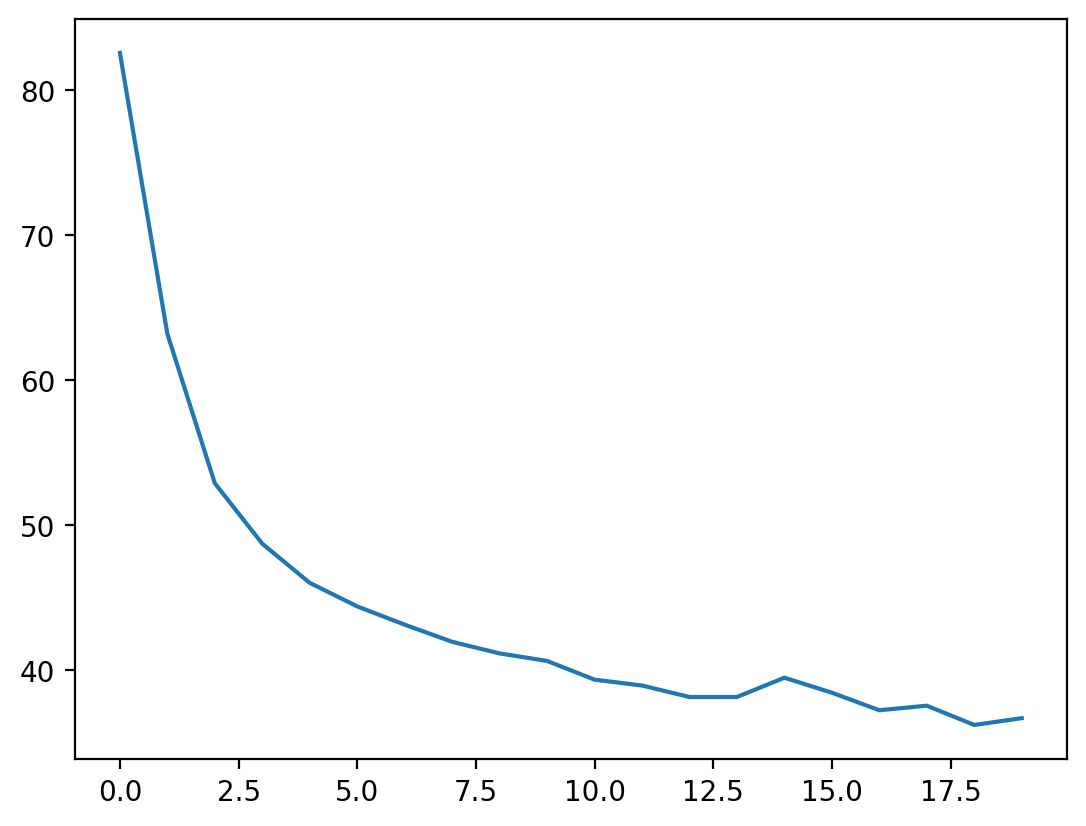

In [28]:
plt.plot(vega_losses)

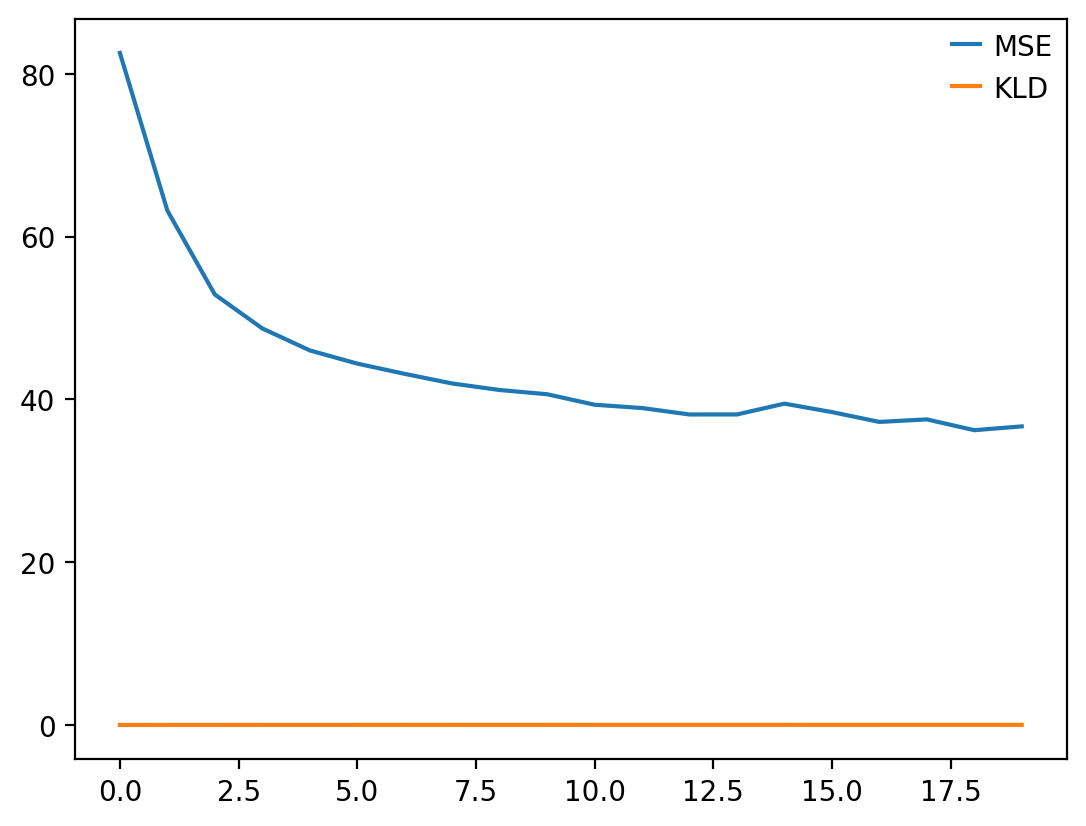

In [29]:
# plot mse and kld
plt.plot(vega_mses, label = "MSE")
plt.plot(vega_klds, label = "KLD")
plt.legend()

In [30]:
# we can see that all decoder weights are positive:
print(torch.sum(vega.state_dict()["decoder.sparse_layer.0.weight"]<0)) # zero negative weights

tensor(425, device='cuda:0')


In [31]:
def to_latent(vae, adata):
        latent = []
        data = torch.tensor(adata.X.toarray()).to(device)
        vae.eval() # we need to set the model to evaluation mode, so that the dropout is no longer considered
        z = vae.encoder(data)
        latent += [z.to("cpu")]
        return torch.cat(latent).detach().numpy()

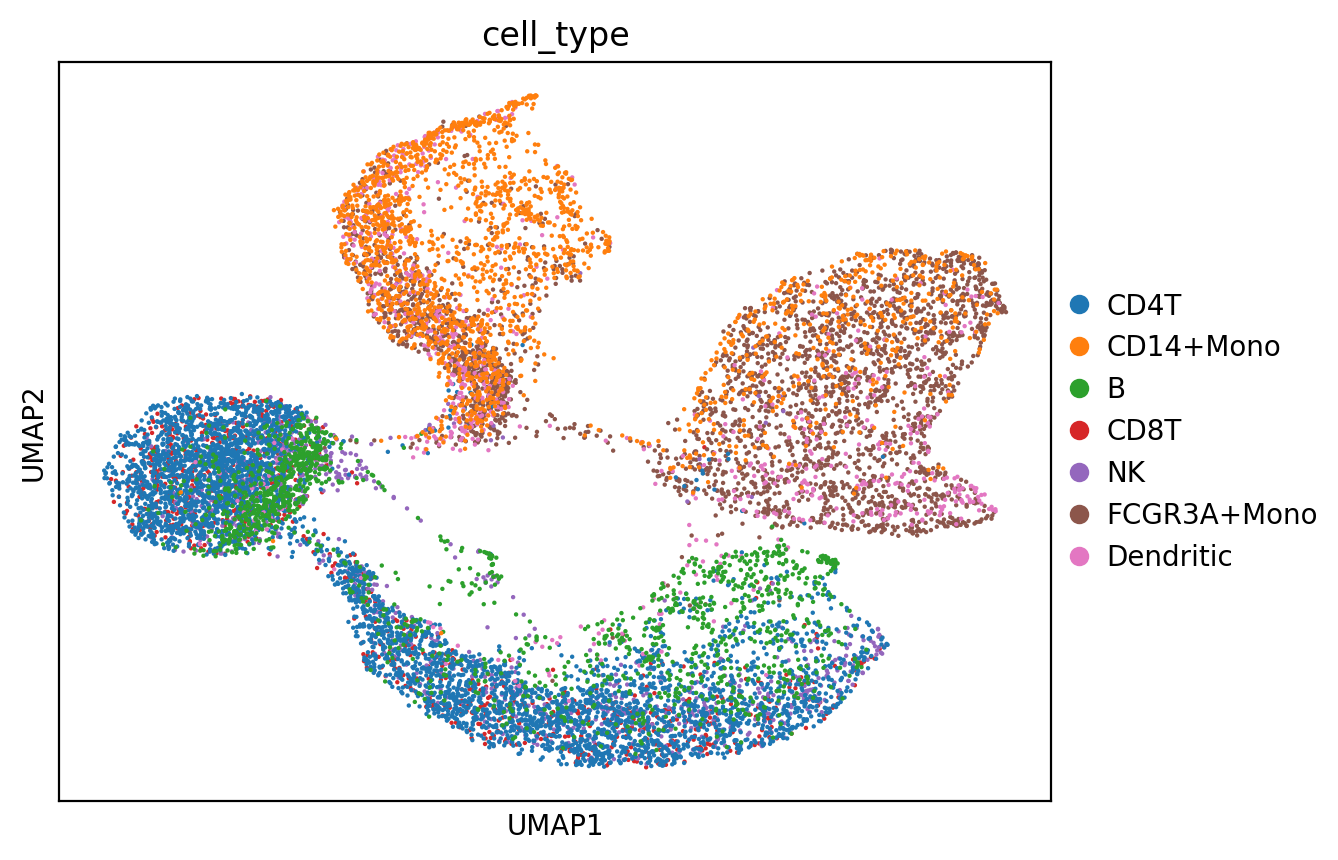

In [32]:
pmbc_genes_subset.obsm["latent_embedding"] = to_latent(vega, pmbc_genes_subset) # project the cells to the model's latent space

# UMAP based on the latent embedding
sc.pp.neighbors(pmbc_genes_subset, use_rep='latent_embedding', n_neighbors=15)

sc.tl.umap(pmbc_genes_subset, random_state=1) #set random state to ensure reproducibility

sc.pl.umap(pmbc_genes_subset, color=["cell_type"], size=10, ncols = 1)

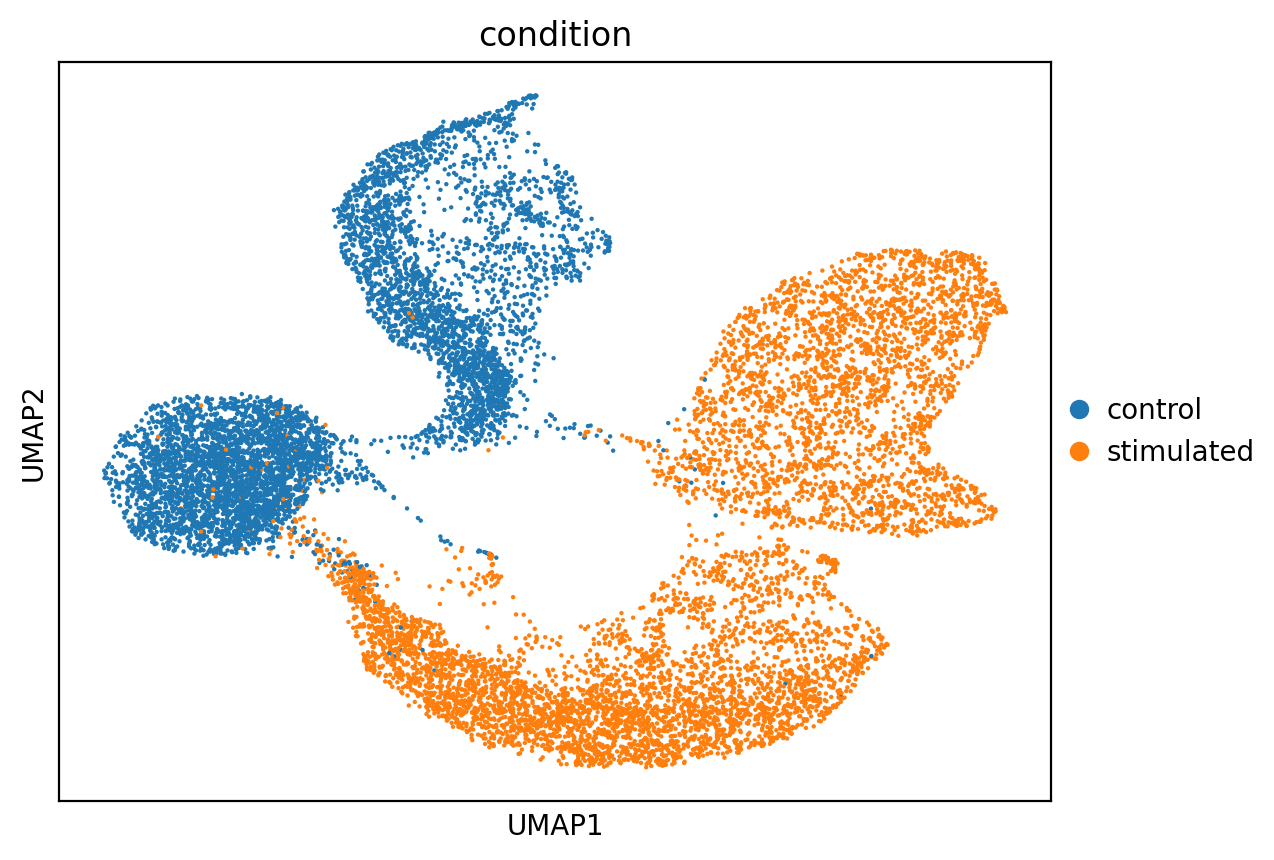

In [33]:
sc.pl.umap(pmbc_genes_subset, color=["condition"], size=10, ncols = 1)

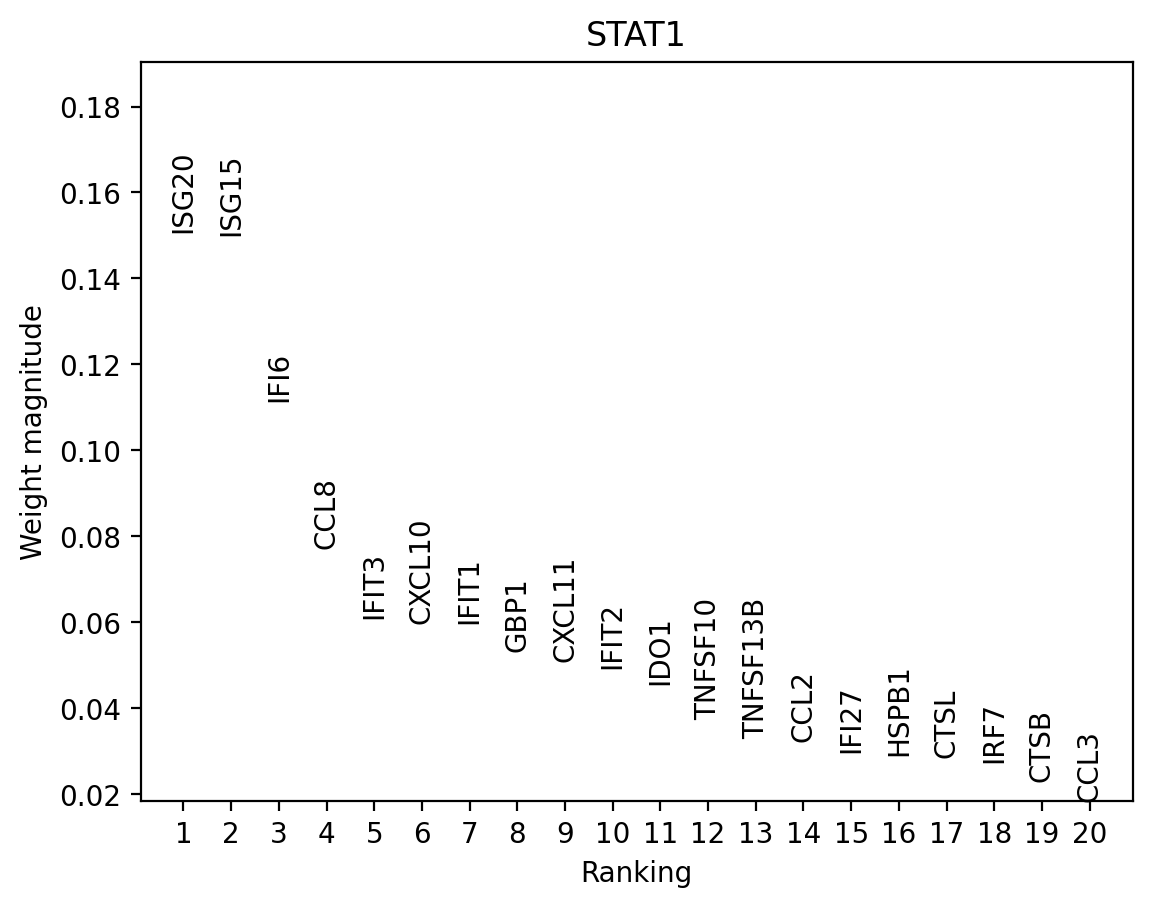

In [34]:
def plot_ranked_gene_weights(model: VEGA, adata,
                        gmv,
                        n_genes: int = 10):
    """
    Plot gene members of input GMVs according to their magnitude.
    """
    w = vega.state_dict()["decoder.sparse_layer.0.weight"].to("cpu")
    gmv_names = list(adata.uns['_vega']['gmv_names'])
    gene_names = adata.var.index.tolist()


    # Get values
    i = gmv_names.index(gmv)
    w_i = w[:,i].detach().numpy()
    sort_idx = np.argsort(w_i)[::-1]
    sort_w = w_i[sort_idx][:n_genes]
    genes = np.array(gene_names)[sort_idx][:n_genes]

    # Set plot params
    ymin = np.min(sort_w)
    ymax = np.max(sort_w)
    ymax += 0.3*(ymax - ymin)

    # Plot
    for ig, gene_name in enumerate(genes):
        plt.text(
            ig,
            sort_w[ig],
            gene_name,
            rotation='vertical',
            verticalalignment='bottom',
            horizontalalignment='center',
            color="black"
        )
    plt.title(gmv)
    plt.ylim(ymin, ymax)
    plt.xlim(-0.9, n_genes - 0.1)
    plt.xlabel('Ranking')
    plt.ylabel('Weight magnitude')
    plt.xticks(np.arange(0, n_genes, step=1), labels = np.arange(1, n_genes+1, step=1))

    plt.show()

plot_ranked_gene_weights(vega, gmv= "STAT1", adata = pmbc_genes_subset, n_genes = 20)

In [35]:
import pandas as pd

def Dataframecombined_2(pbmc, trans, rep, nome):
    mask = create_mask(pbmc).drop("target").to_numpy()
    print("mask done")
    # Estrai nome condizione (modifica se la chiave è diversa)
    cond_name = nome

    # Crea DataLoader
    pbmcX = torch.utils.data.DataLoader(pbmc.X.toarray(), batch_size=128)

    # DataFrame finale
    dfs = pd.DataFrame(columns=['iteration', 'tf', 'gene', 'wei', 'cond'])

    for i in range(rep):
        if i % 2 == 0:
            print(f"Iteration: {i}")

        # Inizializza e addestra VEGA
        vega = VEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, z_dropout = 0.5, dropout = 0.3, clamp_mu=True).to(device)
        # model training
        vega, vega_losses, vega_klds, vega_mses = trainVEGA(vega, pbmcX, epochs = 100, beta = 0.0001) #takes about 2 mins on GPU
        pbmc.obsm["latent_embedding"] = to_latent(vega, pbmc) # project the cells to the model's latent space

# UMAP based on the latent embedding
        #sc.pp.neighbors(pbmc, use_rep='latent_embedding', n_neighbors=15)

        #sc.tl.umap(pbmc, random_state=1) #set random state to ensure reproducibility

        #sc.pl.umap(pbmc, color=["cell_type"], size=10, ncols = 1)
        #sc.pl.umap(pbmc, color=["condition"], size=10, ncols = 1)
        # Ottieni pesi
        weights = vega.decoder.weights().detach().cpu().numpy()

        # Assumi che tf_names e gmv_names siano disponibili
        tf_names = pbmc.uns["_vega"]["gmv_names"]
        gene_names = pbmc.var_names

        # Verifica le dimensioni
        assert len(gene_names) == weights.shape[0], "Mismatch tra numero geni e righe dei pesi"
        assert len(tf_names) == weights.shape[1], "Mismatch tra numero TF e colonne dei pesi"

        # Costruzione delle righe
        rows = [
            {
                'iteration': i,
                'tf': tf_names[tf_idx],
                'gene': gene_names[gene_idx],
                'wei': weights[gene_idx][tf_idx],
                'cond': cond_name
            }
            for gene_idx in range(len(gene_names))
            for tf_idx in range(len(tf_names))
        ]

        df = pd.DataFrame(rows)
        dfs = pd.concat([dfs, df], ignore_index=True)

    return dfs

In [36]:
pmbc_control=pmbc_genes_subset[pmbc_genes_subset.obs["condition"] == "control"]
pmbc_stimulated=pmbc_genes_subset[pmbc_genes_subset.obs["condition"] == "stimulated"]
combined_df_c=Dataframecombined_2(pmbc_control,filtered_regulons, 20, "control")
combined_df_s=Dataframecombined_2(pmbc_stimulated,filtered_regulons, 20, "stimulated")
union=pd.concat([combined_df_c,combined_df_s])
union

mask done
Iteration: 0
epoch:  0  loss:  65.289406
epoch:  1  loss:  55.58983
epoch:  2  loss:  47.74836
epoch:  3  loss:  41.002384
epoch:  4  loss:  36.27411
epoch:  5  loss:  34.005966
epoch:  6  loss:  32.499393
epoch:  7  loss:  31.453115
epoch:  8  loss:  30.851788
epoch:  9  loss:  30.139431
epoch:  10  loss:  29.726526
epoch:  11  loss:  29.398436
epoch:  12  loss:  29.098433
epoch:  13  loss:  28.58299
epoch:  14  loss:  28.405472
epoch:  15  loss:  28.077354
epoch:  16  loss:  27.849157
epoch:  17  loss:  27.57654
epoch:  18  loss:  27.504013
epoch:  19  loss:  27.220432
epoch:  20  loss:  26.919224
epoch:  21  loss:  26.825056
epoch:  22  loss:  26.524225
epoch:  23  loss:  26.40383
epoch:  24  loss:  26.24171
epoch:  25  loss:  25.906178
epoch:  26  loss:  25.803944
epoch:  27  loss:  25.723843
epoch:  28  loss:  25.645676
epoch:  29  loss:  25.43746
epoch:  30  loss:  25.27311
epoch:  31  loss:  25.052261
epoch:  32  loss:  25.21932
epoch:  33  loss:  25.051188
epoch:  34 

/tmp/ipykernel_11456/1188006065.py:23: ImplicitModificationWarning: Setting element `.obsm['latent_embedding']` of view, initializing view as actual.
  pbmc.obsm["latent_embedding"] = to_latent(vega, pbmc) # project the cells to the model's latent space
/tmp/ipykernel_11456/1188006065.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat([dfs, df], ignore_index=True)


epoch:  0  loss:  64.59449
epoch:  1  loss:  55.133564
epoch:  2  loss:  48.39555
epoch:  3  loss:  42.19552
epoch:  4  loss:  37.99468
epoch:  5  loss:  36.09931
epoch:  6  loss:  34.60358
epoch:  7  loss:  33.74851
epoch:  8  loss:  32.670895
epoch:  9  loss:  32.01455
epoch:  10  loss:  31.499512
epoch:  11  loss:  30.696852
epoch:  12  loss:  30.246462
epoch:  13  loss:  29.955894
epoch:  14  loss:  29.22121
epoch:  15  loss:  28.93599
epoch:  16  loss:  28.595146
epoch:  17  loss:  28.282877
epoch:  18  loss:  27.886875
epoch:  19  loss:  27.451584
epoch:  20  loss:  27.139153
epoch:  21  loss:  27.061813
epoch:  22  loss:  26.886543
epoch:  23  loss:  26.66105
epoch:  24  loss:  26.388538
epoch:  25  loss:  26.168163
epoch:  26  loss:  26.009165
epoch:  27  loss:  25.744335
epoch:  28  loss:  25.88157
epoch:  29  loss:  25.619232
epoch:  30  loss:  25.56468
epoch:  31  loss:  25.477697
epoch:  32  loss:  25.261467
epoch:  33  loss:  25.140926
epoch:  34  loss:  24.922699
epoch:  

/tmp/ipykernel_11456/1188006065.py:23: ImplicitModificationWarning: Setting element `.obsm['latent_embedding']` of view, initializing view as actual.
  pbmc.obsm["latent_embedding"] = to_latent(vega, pbmc) # project the cells to the model's latent space
/tmp/ipykernel_11456/1188006065.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat([dfs, df], ignore_index=True)


epoch:  0  loss:  109.26703
epoch:  1  loss:  90.69373
epoch:  2  loss:  71.885315
epoch:  3  loss:  60.791393
epoch:  4  loss:  55.281
epoch:  5  loss:  51.641106
epoch:  6  loss:  49.900642
epoch:  7  loss:  50.609226
epoch:  8  loss:  47.783073
epoch:  9  loss:  46.15781
epoch:  10  loss:  45.357754
epoch:  11  loss:  44.507374
epoch:  12  loss:  44.269173
epoch:  13  loss:  43.46519
epoch:  14  loss:  42.74859
epoch:  15  loss:  42.50771
epoch:  16  loss:  42.058983
epoch:  17  loss:  41.296875
epoch:  18  loss:  41.06321
epoch:  19  loss:  42.258884
epoch:  20  loss:  39.799397
epoch:  21  loss:  39.940975
epoch:  22  loss:  39.83319
epoch:  23  loss:  39.190464
epoch:  24  loss:  39.439564
epoch:  25  loss:  38.79609
epoch:  26  loss:  39.529106
epoch:  27  loss:  38.214302
epoch:  28  loss:  37.800007
epoch:  29  loss:  37.24924
epoch:  30  loss:  37.426643
epoch:  31  loss:  37.423225
epoch:  32  loss:  36.740532
epoch:  33  loss:  36.65019
epoch:  34  loss:  36.23315
epoch:  3

,iteration,tf,gene,wei,cond
0,0,STAT5A,IL2,0.000070,control
1,0,STAT5B,IL2,0.000703,control
2,0,STAT4,IL2,-0.000000,control
3,0,IRF1,IL2,0.000000,control
4,0,STAT3,IL2,-0.000522,control
...,...,...,...,...,...
107095,19,IRF5,ZNF655,-0.000000,stimulated
107096,19,STAT2,ZNF655,-0.000000,stimulated
107097,19,IRF7,ZNF655,-0.000000,stimulated
107098,19,IRF9,ZNF655,0.000000,stimulated


<Axes: xlabel='tf', ylabel='wei'>

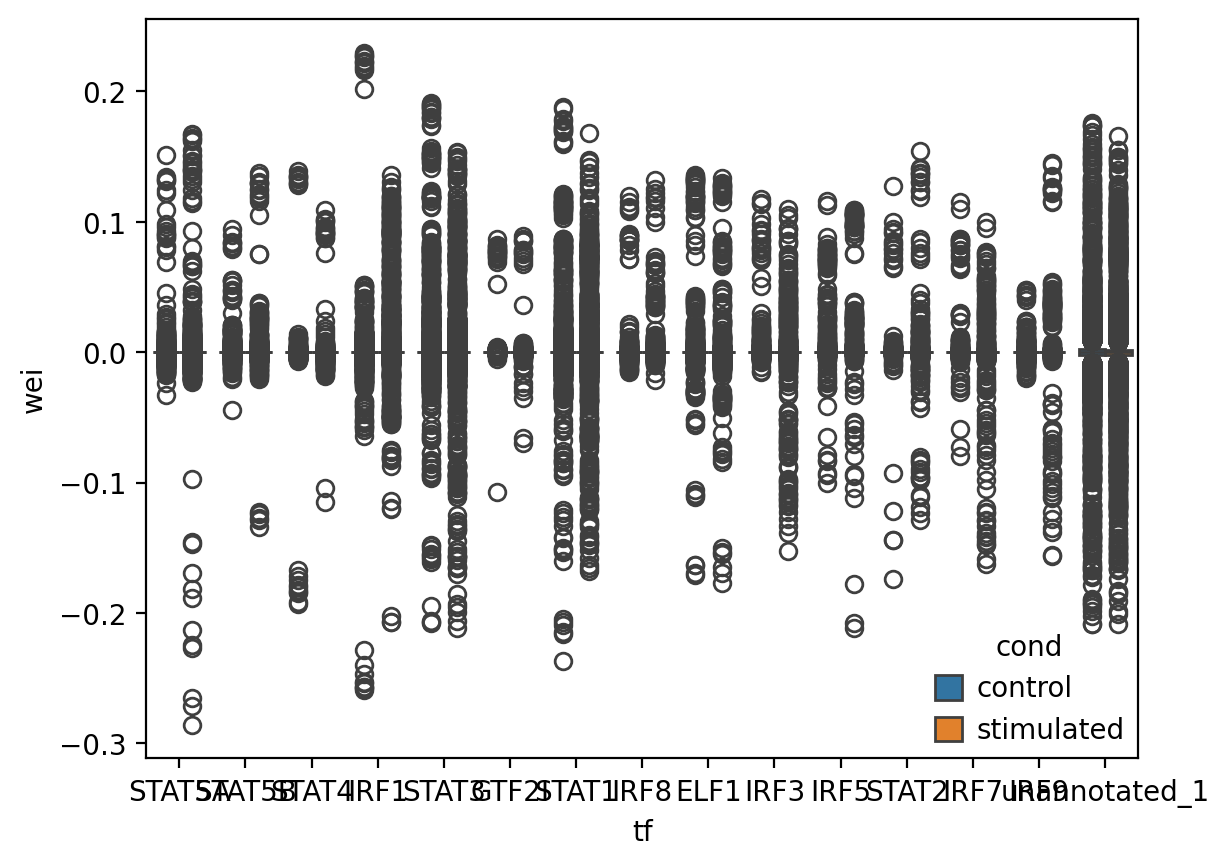

In [37]:
import seaborn as sns
sns.boxplot(union, x="tf", y="wei", hue="cond")

In [41]:
pl.from_pandas(union).write_csv("vega_weights_default_mu_clamp.csv", separator="\t")